## Composite Bayesian Optimization with Multi-Task Gaussian Processes

In this tutorial, we'll be describing how to perform multi-task Bayesian optimization over composite functions. In these types of problems, there are several related outputs, and an overall easy to evaluate objective function that we wish to maximize.

**Multi-task Bayesian Optimization** was first proposed by [Swersky et al, NeurIPS, '13](https://papers.neurips.cc/paper/2013/hash/f33ba15effa5c10e873bf3842afb46a6-Abstract.html) in the context of fast hyper-parameter tuning for neural network models; however, we demonstrate a more advanced use-case of **[composite Bayesian optimization](https://proceedings.mlr.press/v97/astudillo19a.html)** where the overall function that we wish to optimize is a cheap-to-evaluate (and known) function of the outputs. In general, we expect that using more information about the function should yield improved performance when attempting to optimize it, particularly if the metric function itself is quickly varying.

See [the composite BO tutorial w/ HOGP](https://github.com/meta-pytorch/botorch/blob/main/tutorials/composite_bo_with_hogp/composite_bo_with_hogp.ipynb) for a more technical introduction. In general, we suggest using MTGPs for unstructured task outputs and the HOGP for matrix / tensor structured outputs.


We will use a Multi-Task Gaussian process ([MTGP](https://papers.nips.cc/paper/2007/hash/66368270ffd51418ec58bd793f2d9b1b-Abstract.html)) with an ICM kernel to model all of the outputs in this problem. MTGPs can be easily accessed in Botorch via the `botorch.models.KroneckerMultiTaskGP` model class (for the "block design" case of fully observed outputs at all inputs). Given $T$ tasks (outputs) and $n$ data points, they assume that the responses, $Y \sim \mathbb{R}^{n \times T},$ are distributed as $\text{vec}(Y) \sim \mathcal{N}(f, D)$ and $f \sim \mathcal{GP}(\mu_{\theta}, K_{XX} \otimes K_{T}),$ where $D$ is a (diagonal) noise term.

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os
import time

import torch
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.acquisition.objective import GenericMCObjective
from botorch.models import KroneckerMultiTaskGP
from botorch.optim import optimize_acqf
from botorch.sampling.normal import IIDNormalSampler

from botorch.test_functions import Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings
warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### Set device, dtype and random seed

In [3]:
torch.random.manual_seed(10)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

### Problem Definition

The function that we wish to optimize is based off of a contextual version of the Hartmann-6 test function, where following [Feng et al, NeurIPS, '20](https://proceedings.neurips.cc/paper/2020/hash/faff959d885ec0ecf70741a846c34d1d-Abstract.html) we convert the sixth task dimension into a task indicator. Here we assume that we evaluate all contexts at once.

In [4]:
from torch import Tensor


class ContextualHartmann6(Hartmann):
    def __init__(self, num_tasks: int = 20, noise_std=None, negate=False):
        super().__init__(dim=6, noise_std=noise_std, negate=negate)
        self.task_range = torch.linspace(0, 1, num_tasks).unsqueeze(-1)
        self.dim = 5
        self._bounds = [(0.0, 1.0) for _ in range(self.dim)]
        self.bounds = torch.tensor(self._bounds).t()

    def _evaluate_true(self, X: Tensor) -> Tensor:
        batch_X = X.unsqueeze(-2)
        batch_dims = X.ndim - 1

        expanded_task_range = self.task_range
        for _ in range(batch_dims):
            expanded_task_range = expanded_task_range.unsqueeze(0)
        task_range = expanded_task_range.repeat(*X.shape[:-1], 1, 1).to(X)
        concatenated_X = torch.cat(
            (
                batch_X.repeat(*[1] * batch_dims, self.task_range.shape[0], 1),
                task_range,
            ),
            dim=-1,
        )
        return super()._evaluate_true(concatenated_X)

We use `GenericMCObjective` to define the differentiable function that we are optimizing. Here, it is defined as 
$$g(f) = \sum_{i=1}^T \cos(f_i^2 + f_i w_i)$$
where $w$ is a weight vector (drawn randomly once at the start of the optimization). As this function is a non-linear function of the outputs $f,$ we cannot compute acquisition functions via computation of the posterior mean and variance, but rather have to compute posterior samples and evaluate acquisitions with Monte Carlo sampling. 

For greater than $10$ or so tasks, it is computationally challenging to sample the posterior over all tasks jointly using conventional approaches, except that [Maddox et al, '21](https://arxiv.org/abs/2106.12997) have devised an efficient method for exploiting the structure in the posterior distribution of the MTGP, enabling efficient MC based optimization of objectives using MTGPs. In this tutorial, we choose 6  contexts/tasks for demonstration. 

In [5]:
num_tasks = 6
problem = ContextualHartmann6(num_tasks=num_tasks, noise_std=0.001, negate=True).to(**tkwargs)

# we choose num_tasks random weights
weights = torch.randn(num_tasks, **tkwargs)


def callable_func(samples, X=None):
    res = -torch.cos((samples**2) + samples * weights)
    return res.sum(dim=-1)


objective = GenericMCObjective(callable_func)

In [6]:
bounds = problem.bounds

## BO Loop

Set environmental parameters, we use 20 initial data points and optimize for 20 steps with a batch size of 3 candidate points at each evaluation.

In [7]:
if SMOKE_TEST:
    n_init = 5
    n_steps = 1
    batch_size = 2
    num_samples = 4
    # For L-BFGS inner optimization loop
    MAXITER = 10
else:
    n_init = 10
    n_steps = 10
    batch_size = 3
    num_samples = 64
    MAXITER = 200

In [8]:
from botorch.fit import fit_gpytorch_mll

Finally, run the optimization loop.

Warning... this optimization loop can take a while, especially on the CPU. We compare to random sampling. 

In [9]:
# New version
torch.manual_seed(0)

init_x = (bounds[1] - bounds[0]) * torch.rand(
    n_init, bounds.shape[1], **tkwargs
) + bounds[0]

init_y = problem(init_x)

mtgp_train_x, mtgp_train_y = init_x, init_y
rand_x, rand_y = init_x, init_y

best_value_mtgp = objective(init_y).max()
best_random = best_value_mtgp

for iteration in range(n_steps):
    # we empty the cache to clear memory out
    torch.cuda.empty_cache()

    # MTGP
    mtgp_t0 = time.monotonic()
    mtgp = KroneckerMultiTaskGP(mtgp_train_x, mtgp_train_y)
    mtgp_mll = ExactMarginalLogLikelihood(mtgp.likelihood, mtgp)
    fit_gpytorch_mll(mll=mtgp_mll, optimizer_kwargs={"options": {"maxiter": 50}})

    sampler = IIDNormalSampler(sample_shape=torch.Size([num_samples]))
    mtgp_acqf = qLogExpectedImprovement(
        model=mtgp,
        best_f=best_value_mtgp,
        sampler=sampler,
        objective=objective,
    )
    new_mtgp_x, _ = optimize_acqf(
        acq_function=mtgp_acqf,
        bounds=bounds,
        q=batch_size,
        num_restarts=10,
        raw_samples=512,  # used for initialization heuristic
        options={"batch_limit": 5, "maxiter": MAXITER, "init_batch_limit": 5},
    )
    mtgp_train_x = torch.cat((mtgp_train_x, new_mtgp_x), dim=0)
    mtgp_train_y = torch.cat((mtgp_train_y, problem(new_mtgp_x)), dim=0)
    best_value_mtgp = objective(mtgp_train_y).max()
    mtgp_t1 = time.monotonic()

    # rand
    new_rand_x = (bounds[1] - bounds[0]) * torch.rand(
        batch_size, bounds.shape[1], **tkwargs
    ) + bounds[0]
    rand_x = torch.cat((rand_x, new_rand_x))
    rand_y = torch.cat((rand_y, problem(new_rand_x)))
    best_random = objective(rand_y).max()

    print(
        f"\nBatch {iteration:>2}: best_value (random, mtgp) = "
        f"({best_random:>4.2f}, {best_value_mtgp:>4.2f}, "
        f"mtgp time = {mtgp_t1-mtgp_t0:>4.2f}",
        end="",
    )

objectives = {
    "MGTP": objective(mtgp_train_y).detach().cpu(),
    "Random": objective(rand_y).detach().cpu(),
}


Batch  0: best_value (random, mtgp) = (-3.91, -4.76, mtgp time = 5.89


Batch  1: best_value (random, mtgp) = (-3.91, -4.76, mtgp time = 1.65


Batch  2: best_value (random, mtgp) = (-3.91, -4.76, mtgp time = 3.66


Batch  3: best_value (random, mtgp) = (-3.91, -3.16, mtgp time = 1.60


Batch  4: best_value (random, mtgp) = (-3.91, -3.16, mtgp time = 1.40


Batch  5: best_value (random, mtgp) = (-3.91, -3.15, mtgp time = 10.46


Batch  6: best_value (random, mtgp) = (-3.91, -2.53, mtgp time = 1.55


Batch  7: best_value (random, mtgp) = (-3.91, -2.53, mtgp time = 3.06


Batch  8: best_value (random, mtgp) = (-3.91, -2.53, mtgp time = 2.06


Batch  9: best_value (random, mtgp) = (-3.91, -2.53, mtgp time = 2.38

### Plot Results

In [10]:
import matplotlib.pyplot as plt

Finally, we plot the results. MTGP will outperform the random baseline.

In [11]:
results = {
    k: t[n_init:].cummax(0).values for k, t in objectives.items()
}

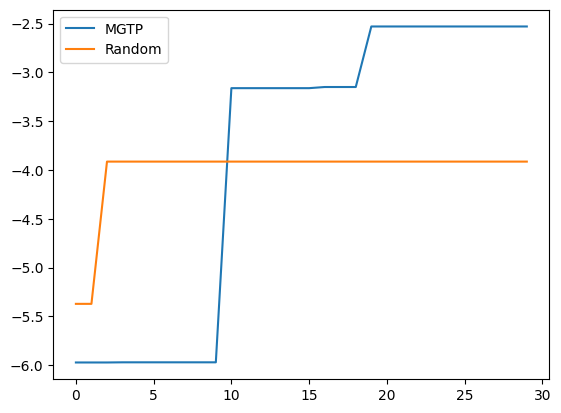

In [12]:
for name, vals in results.items():
    plt.plot(vals, label=name)
plt.legend()
plt.show()